<a href="https://colab.research.google.com/github/hsuanchia/Image-caption/blob/main/generate_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json,pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import load_model,Model
from PIL import Image 
from tqdm import tqdm

In [2]:
def load_image(path, size=None):
  """
  Load the image from the given file-path and resize it
  to the given size if not None.
  """
  # Load the image using PIL.
  img = Image.open(path)

  # Resize image if desired.
  img = img.resize(size=(224,224), resample=Image.LANCZOS)

  # Convert image to numpy array.
  img = np.array(img)

  # Scale image-pixels so they fall between 0.0 and 1.0
  img = img / 255.0

  # Convert 2-dim gray-scale array to 3-dim RGB array.
  if (len(img.shape) == 2):
      img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
  return img

In [3]:
image_model = VGG16(include_top=True,weights='imagenet')
image_model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [4]:
img_size = K.int_shape(image_model.input)[1:3]
transfer_layer = image_model.get_layer('fc2')
encoder_model = Model(inputs=image_model.input,outputs=transfer_layer.output)
value_size = K.int_shape(transfer_layer.output)[1]

In [5]:
max_length = 30
start = '<start>'
end = '<end>'

# val_voc_10.pkl
* 內容包含: word_index 跟 inv_word_index
* 檔名的10代表取整個annotation的詞中出現次數超過10的詞彙
* 根據model使用的資料可能會需要不同的voc

In [6]:
def generate_caption(model_path,img_path,show=True):
  p = open('/content/drive/MyDrive/MSCOCO_2017/val_voc_10.pkl','rb') # 根據model用的data，需更換VOC
  voc_data = pickle.load(p)
  word_index = voc_data['word_index']
  inv_word_index = voc_data['inv_word_index']
  voc_size = len(word_index) + 1

  decoder_model = load_model(model_path)
  img = load_image(img_path)
  image_batch = np.expand_dims(img, axis=0)
  img_data = encoder_model.predict(image_batch,verbose=0)
  decoder_input = np.zeros((1,max_length),dtype='float32')
  token_cur = word_index[start]
  output_text = ''
  count_tokens = 0
  while token_cur != word_index[end] and count_tokens < max_length:
    decoder_input[0,count_tokens] = token_cur
    decoder_output = decoder_model.predict([img_data,decoder_input])
    token_cur = np.argmax(decoder_output[0,count_tokens]) 
    cur_word = inv_word_index[token_cur]
    if(cur_word != end):
      output_text += " " + cur_word
    count_tokens += 1
  if show:
    test_image = plt.imread(img_path)
    plt.imshow(test_image)
    plt.show()
    print("Caption:")
    print(output_text)
    return output_text
  else:
    return output_text

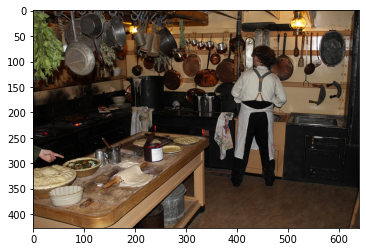

Caption:
 a woman standing in front of a table in a room


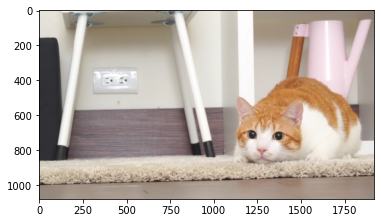

Caption:
 a cat sitting on a laptop computer screen


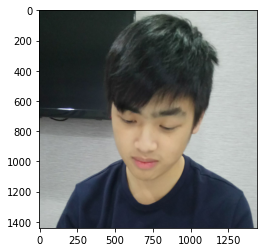

Caption:
 a dog that is standing up on the floor


' a dog that is standing up on the floor'

In [7]:
#上方的所有code都要跑過
#只要更改你要用的model檔案位置跟你要caption的檔案位置就可以用了

model_path = '/content/drive/MyDrive/MSCOCO_2017/model_noatt25000data.h5'
generate_caption(model_path,'/content/drive/MyDrive/MSCOCO_2017/val2017/000000397133.jpg')
generate_caption(model_path,'/content/drive/MyDrive/eggroll.jpg')
generate_caption(model_path,'/content/drive/MyDrive/me.jpg')

# 後面需要補用來算BLEU的code